In [1]:
# %load_ext autotime
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess
import argparse
import random
import subprocess
import os
import time
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import esm
import biotite.structure.io as bsio
# from biopandas.pdb import PandasPdb
from pathlib import Path
from datetime import datetime

import Bio
import Bio.PDB as bp

def calculate_tm_score(
    pred_path, pdb_path, chain_id=None, use_tmalign=True, verbose=False,
    tmscore_path="/scratch/project/open-29-57/antonb/ttt/TTTProt/folding/TMalign",
    tmalign_path="/scratch/project/open-29-57/antonb/ttt/TTTProt/folding/TMalign_cpp"
):

    if chain_id is not None:
        raise NotImplementedError("Chain ID is not implemented for TM-score calculation.")

    # Run TMscore and capture the output
    command = [tmalign_path, pdb_path, pred_path] if use_tmalign else [tmscore_path, pred_path, pdb_path]
    result = subprocess.run(
        command,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )

    def print_cmd():
        print("TMscore command:")
        print(result.args)
        print("TMscore output:")
        print(result.stdout)
        print("TMscore error:")
        print(result.stderr)
    if verbose:
        print_cmd()

    # Extract TM-score from the output
    for line in result.stdout.split('\n'):
        if line.startswith("TM-score"):
            tm_score = float(line.split('=')[1].split()[0])
            return tm_score

    print_cmd()
    raise ValueError("TM-score not found in the output")

In [2]:
# !pip install autotime

In [2]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")

/scratch/project/open-32-14/pimenol1/miniconda3/envs/proteinttt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: False


In [12]:
from pathlib import Path
import os
import warnings
import pandas as pd
import tqdm
from Bio.PDB import PDBParser

import esm
import biotite.structure.io as bsio

from proteinttt.models.esmfold import ESMFoldTTT, DEFAULT_ESMFOLD_TTT_CFG

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 10000)
pd.set_option("max_colwidth", 100)
base_path = Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/all_structures")
SABDAB_SUMMARY_PATH = base_path / Path("sabdab_summary_all.tsv")
OUTPUT_PATH = base_path / Path('predicted_structures')
PDB_FILES_PATH = base_path / Path("raw")
os.makedirs(OUTPUT_PATH, exist_ok=True)

print(f"Summary file: {SABDAB_SUMMARY_PATH}")
print(f"PDB files path: {PDB_FILES_PATH}")
print(f"Output will be saved to: {OUTPUT_PATH}")

Summary file: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/all_structures/sabdab_summary_all.tsv
PDB files path: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/all_structures/raw
Output will be saved to: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/all_structures/predicted_structures


In [13]:
df = pd.read_csv(SABDAB_SUMMARY_PATH, sep="\t", low_memory=False)
print(f"Entries in summary: {len(df):,}")
df.head(5)

Entries in summary: 19,219


,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,compound,organism,heavy_species,light_species,antigen_species,authors,resolution,method,r_free,r_factor,scfv,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid
0,9ei9,A,D,0,C,protein,NaN,hemagglutinin ha1,IMMUNE SYSTEM,07/16/25,Cryo-EM structure of 5E10 Fab in complex with H3 influenza Victoria 2011 HA trimer,Influenza A virus; Mus musculus,mus musculus,mus musculus,influenza a virus,"Gorman, J., Kwong, P.D.",3.89,ELECTRON MICROSCOPY,NaN,NaN,False,True,IGHV8,IGLV2,Lambda,NaN,NaN,NaN,NaN,NaN
1,9ei9,H,J,0,B | F | E,protein | protein | protein,NA | NA | NA,hemagglutinin ha1 | hemagglutinin ha2 | hemagglutinin ha2,IMMUNE SYSTEM,07/16/25,Cryo-EM structure of 5E10 Fab in complex with H3 influenza Victoria 2011 HA trimer,Influenza A virus; Mus musculus,mus musculus,mus musculus,influenza a virus | influenza a virus | influenza a virus,"Gorman, J., Kwong, P.D.",3.89,ELECTRON MICROSCOPY,NaN,NaN,False,True,IGHV8,IGLV2,Lambda,NaN,NaN,NaN,NaN,NaN
2,8z9o,N,NaN,0,C | B,protein | protein,NA | NA,isoform gnas-2 of guanine nucleotide-binding protein g(s)subunit alpha isoforms short | guanine...,MEMBRANE PROTEIN/IMMUNE SYSTEM,07/16/25,Cryo-EM structure of human GPR4-Gs complex,Bos taurus; Homo sapiens; Rattus norvegicus; synthetic construct,synthetic construct,NaN,homo sapiens | rattus norvegicus,"Chen, L.N., Mao, C.Y., Cheng, S.Z., Liu, Y.F., Fu, Y.F., Ma, X.Y., Xu, P., Ji, S.Y., Wang, W.W.,...",2.4,ELECTRON MICROSCOPY,NaN,NaN,False,True,IGHV3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9e69,H,L,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,07/16/25,Antibody 5E10,Homo sapiens,homo sapiens,homo sapiens,NaN,"Zhou, T., Sao-Fong Cheung, C., Kwong, P.D.",2.63,X-RAY DIFFRACTION,0.242,0.218,False,True,IGHV8,IGLV2,Lambda,NaN,NaN,NaN,NaN,NaN
4,9e69,A,B,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,07/16/25,Antibody 5E10,Homo sapiens,homo sapiens,homo sapiens,NaN,"Zhou, T., Sao-Fong Cheung, C., Kwong, P.D.",2.63,X-RAY DIFFRACTION,0.242,0.218,False,True,IGHV8,IGLV2,Lambda,NaN,NaN,NaN,NaN,NaN


In [14]:
df["resolution"] = pd.to_numeric(df["resolution"], errors="coerce")
df = df.query("resolution < 2.0").copy()

In [34]:
def parse_antibody_data(df: pd.DataFrame, pdb_dir: Path):
    parser = PDBParser(QUIET=True)
    three_to_one = {
        "ALA": "A", "CYS": "C", "ASP": "D", "GLU": "E", "PHE": "F", "GLY": "G", "HIS": "H",
        "ILE": "I", "LYS": "K", "LEU": "L", "MET": "M", "ASN": "N", "PRO": "P", "GLN": "Q", "ARG": "R",
        "SER": "S", "THR": "T", "VAL": "V", "TRP": "W", "TYR": "Y"
    }

    def extract_chain_sequence(chain_id, structure):
        seq = []
        for chain in structure.get_chains():
            if chain.id == chain_id:
                for res in chain.get_residues():
                    if res.id[0] == " ":
                        seq.append(three_to_one.get(res.resname, "X"))
        return "".join(seq)

    for i, row in df.iterrows():
        pdb_code = row["pdb"].lower()
        pdb_path = pdb_dir / f"{pdb_code}.pdb"

        try:
            structure = parser.get_structure(pdb_code, pdb_path)
            seqH = extract_chain_sequence(row["Hchain"], structure)
            seqL = extract_chain_sequence(row["Lchain"], structure)
        except Exception as e:
            seqH = seqL = f"ERROR: {e}"

        df.at[i, "seqH"] = seqH
        df.at[i, "seqL"] = seqL
        df.at[i, "full_sequence"] = f"{seqH}:{seqL}"

    return df

df_with_seq = parse_antibody_data(df, PDB_FILES_PATH)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

base_model = esm.pretrained.esmfold_v1().eval().to(device)

ttt_cfg = DEFAULT_ESMFOLD_TTT_CFG
ttt_cfg.steps = 20          
ttt_cfg.batch_size = 4           
ttt_cfg.seed = 0
# ttt_cfg.lr = 2e-4
model = ESMFoldTTT.ttt_from_pretrained(base_model,
                                       ttt_cfg=ttt_cfg,
                                       esmfold_config=base_model.cfg).to(device)

Using cuda


In [ ]:
def predict_structure(model, sequence, pdb_id, tag, out_dir=OUTPUT_PATH):
    with torch.no_grad():
        pdb_str = model.infer_pdb(sequence)

    out_path = out_dir / f"{pdb_id.lower()}_{tag}.pdb"
    out_path.write_text(pdb_str)
    
    struct = bsio.load_structure(out_path, extra_fields=["b_factor"])
    pLDDT = struct.b_factor.mean()
    tm_score = calculate_tm_score(
        pred_path=out_path,
        pdb_path=PDB_FILES_PATH / f"{pdb_id}.pdb")
    if pLDDT < 70:
        print(f'{pdb_id}_{tag}_pLDDT:', pLDDT)
    return pLDDT, tm_score

In [ ]:
def fold_chain(sequence, pdb_id, *, model, tag, out_dir = OUTPUT_PATH):
    """
    Predict a structure for `sequence` with TTT
    return pLDDT.
    The PDB is written as <out_dir>/<pdb_id>_<tag>.pdb
    """
    pLDDT_before, tm_score_before = predict_structure(model, sequence, pdb_id, tag=f'{tag}_before_ttt', out_dir=out_dir)
    
    if pLDDT_before >= 70:
        # print(f"Skipping TTT for {pdb_id} as pLDDT is already high: {pLDDT_before:.2f}")
        return pLDDT_before, None
    
    model.ttt(sequence)
    
    pLDDT_after, tm_score_after = predict_structure(model, sequence, pdb_id, tag=f'{tag}_ttt', out_dir=out_dir)
    
    model.ttt_reset()
    
    return pLDDT_before, pLDDT_after

In [ ]:
for i, row in df.iterrows():
    pdb_id = str(row.get("pdb"))
    chain_map = {"H": "seqH", "L": "seqL"}
    
    for tag, col in chain_map.items():
        if pd.isna(row[col]):
            continue
        seq = str(row[col]).strip().upper()
        tag = f'{str(row[f'{tag}chain'])}'
        
        try:
            pLDDT_before, tm_score_before = predict_structure(model, seq, pdb_id, tag=f'{tag}_before_ttt', out_dir=OUTPUT_PATH)
            df.at[i, 'pLDDT_before'] = pLDDT_before
            df.at[i, 'tm_score_before'] = tm_score_before
        except Exception as e:
            warnings.warn(f"{pdb_id}{tag}: {e}")

In [ ]:
results = []
for i, row in df.iterrows():
    # pdb_id = str(row.get("pdb", default=f"entry{i}"))
    pdb_id = str(row.get("pdb"))
    chain_map = {"H": "seqH", "L": "seqL"}

    for tag, col in chain_map.items():
        if pd.isna(row[col]):
            continue

        seq = str(row[col]).strip().upper()
        tag = f'{str(row[f'{tag}chain'])}'
        try:
            before, after = fold_chain(seq, pdb_id, model=model, tag=tag)
            results.append({"pdb_id": pdb_id,
                            "chain": tag,
                            "length": len(seq),
                            "pLDDT_before" : before,
                            "pLDDT_after": after
                            })
        except Exception as e:
            warnings.warn(f"{pdb_id}{tag}: {e}")

/tmp/ipykernel_210648/4199538084.py:26: UserWarning: 7xj6L: tensors used as indices must be long, byte or bool tensors
  warnings.warn(f"{pdb_id}{tag}: {e}")
/tmp/ipykernel_210648/4199538084.py:26: UserWarning: 7xj8L: tensors used as indices must be long, byte or bool tensors
  warnings.warn(f"{pdb_id}{tag}: {e}")
/tmp/ipykernel_210648/4199538084.py:26: UserWarning: 7xj9L: tensors used as indices must be long, byte or bool tensors
  warnings.warn(f"{pdb_id}{tag}: {e}")


8saq_L_before_ttt_pLDDT: 58.69344096871846
2025-07-22 15:55:31,026 | INFO | step: 0, accumulated_step: 0, loss: None, perplexity: None, ttt_step_time: 0.00000, score_seq_time: 0.00000, eval_step_time: 1.03257, plddt: 58.69344
2025-07-22 15:55:32,606 | INFO | step: 1, accumulated_step: 4, loss: 2.32617, perplexity: None, ttt_step_time: 0.54327, score_seq_time: 0.00000, eval_step_time: 1.03626, plddt: 57.46111
2025-07-22 15:55:34,488 | INFO | step: 2, accumulated_step: 8, loss: 2.25586, perplexity: None, ttt_step_time: 0.51923, score_seq_time: 0.00000, eval_step_time: 1.03188, plddt: 58.97273
2025-07-22 15:55:36,498 | INFO | step: 3, accumulated_step: 12, loss: 2.07812, perplexity: None, ttt_step_time: 0.52949, score_seq_time: 0.00000, eval_step_time: 1.03090, plddt: 59.77554
2025-07-22 15:55:38,057 | INFO | step: 4, accumulated_step: 16, loss: 1.84766, perplexity: None, ttt_step_time: 0.52715, score_seq_time: 0.00000, eval_step_time: 1.03112, plddt: 55.22063
2025-07-22 15:55:39,613 | IN

/tmp/ipykernel_210648/4199538084.py:26: UserWarning: 8dmhL: tensors used as indices must be long, byte or bool tensors
  warnings.warn(f"{pdb_id}{tag}: {e}")
/tmp/ipykernel_210648/4199538084.py:26: UserWarning: 8d7eH: tensors used as indices must be long, byte or bool tensors
  warnings.warn(f"{pdb_id}{tag}: {e}")
/tmp/ipykernel_210648/4199538084.py:26: UserWarning: 8d7eL: tensors used as indices must be long, byte or bool tensors
  warnings.warn(f"{pdb_id}{tag}: {e}")
/tmp/ipykernel_210648/4199538084.py:26: UserWarning: 8il3H: tensors used as indices must be long, byte or bool tensors
  warnings.warn(f"{pdb_id}{tag}: {e}")
/tmp/ipykernel_210648/4199538084.py:26: UserWarning: 8il3L: tensors used as indices must be long, byte or bool tensors
  warnings.warn(f"{pdb_id}{tag}: {e}")
/tmp/ipykernel_210648/4199538084.py:26: UserWarning: 7x93H: tensors used as indices must be long, byte or bool tensors
  warnings.warn(f"{pdb_id}{tag}: {e}")
/tmp/ipykernel_210648/4199538084.py:26: UserWarning:

8c7h_L_before_ttt_pLDDT: 63.310947293447285


KeyboardInterrupt: 

In [11]:
results

[{'pdb_id': '7uow',
  'chain': 'H',
  'length': 222,
  'pLDDT_before': 85.10902424242425,
  'pLDDT_after': None},
 {'pdb_id': '7uow',
  'chain': 'L',
  'length': 215,
  'pLDDT_before': 87.62647274954072,
  'pLDDT_after': None},
 {'pdb_id': '7uow',
  'chain': 'H',
  'length': 222,
  'pLDDT_before': 85.10902424242425,
  'pLDDT_after': None},
 {'pdb_id': '7uow',
  'chain': 'L',
  'length': 215,
  'pLDDT_before': 87.62647274954072,
  'pLDDT_after': None},
 {'pdb_id': '7xj6',
  'chain': 'H',
  'length': 108,
  'pLDDT_before': 89.35503597122303,
  'pLDDT_after': None},
 {'pdb_id': '7xj6',
  'chain': 'H',
  'length': 108,
  'pLDDT_before': 89.35503597122303,
  'pLDDT_after': None},
 {'pdb_id': '7xj6',
  'chain': 'H',
  'length': 108,
  'pLDDT_before': 89.35503597122303,
  'pLDDT_after': None},
 {'pdb_id': '7xj6',
  'chain': 'H',
  'length': 108,
  'pLDDT_before': 89.35503597122303,
  'pLDDT_after': None},
 {'pdb_id': '7xj8',
  'chain': 'H',
  'length': 108,
  'pLDDT_before': 89.35503597122303

In [12]:
results = pd.DataFrame(results)
results.to_csv(OUTPUT_PATH / "ttt_results.tsv", sep="\t", index=False)
OUTPUT_PATH

PosixPath('/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/predicted_structures')

In [5]:
results = pd.read_csv("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/predicted_structures/ttt_results2.tsv", sep="\t")

In [10]:
results = results.query("pLDDT_after.notna()")

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'pLDDT': results['pLDDT_before'] + results['pLDDT_after'],
    'Model': ['ESMFold'] * len(results['pLDDT_before']) + ['ESMFold+ProteinTTT'] * len(results['pLDDT_after'])
})

sns.violinplot(data=df, x='Model', y='pLDDT')
plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [8]:
! pip install seaborn matplotlib

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [ ]:
# res_df = pd.DataFrame(results)
print(f"Finished {len(results)} chains")
display(results.describe().loc[["count", "mean", "min", "max"]])

In [11]:
df = pd.DataFrame({
    'pLDDT': results['pLDDT_before'] + results['pLDDT_after'],
    'Model': ['ESMFold'] * len(results['pLDDT_before']) + ['ESMFold+ProteinTTT'] * len(results['pLDDT_after'])
})

# Violin plot
sns.violinplot(data=df, x='Model', y='pLDDT')
plt.title('Распределение pLDDT до и после кастомизации')
plt.show()

ValueError: array length 80 does not match index length 40

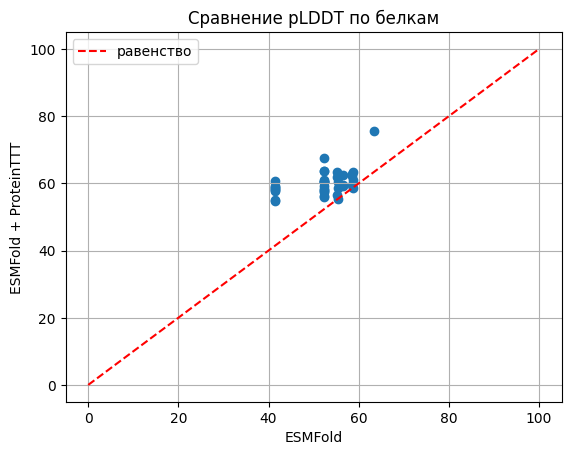

In [12]:
import matplotlib.pyplot as plt

plt.scatter(results['pLDDT_before'], results['pLDDT_after'])
plt.plot([0, 100], [0, 100], 'r--', label='равенство')  
plt.xlabel('ESMFold')
plt.ylabel('ESMFold + ProteinTTT')
plt.title('Сравнение pLDDT по белкам')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
results = results.query("pLDDT_after.notna()")

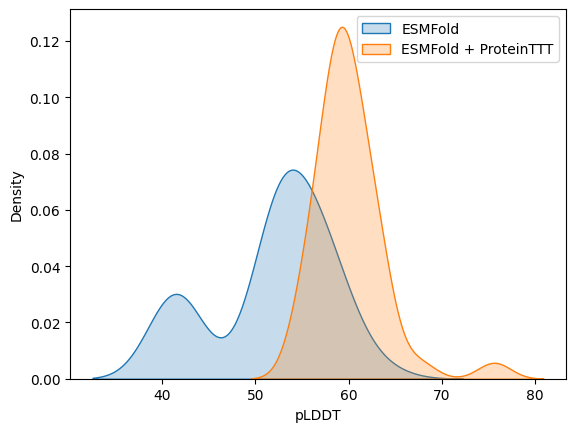

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.kdeplot(results['pLDDT_before'], label='ESMFold', fill=True)
sns.kdeplot(results['pLDDT_after'], label='ESMFold + ProteinTTT', fill=True)
plt.xlabel('pLDDT')
plt.legend()
plt.show()